## 参考文献汇总
- Reference 1: Kaggle Kernel [Code sharing, 13th place, no external data](https://www.kaggle.com/c/rossmann-store-sales/discussion/17979)
- Reference 2: Kaggle Kernel-[A Journey through Rossmann Stores](https://www.kaggle.com/omarelgabry/rossmann-store-sales/a-journey-through-rossmann-stores)
- Reference 3: Kaggle Kernel-[Predict_sales_with_pandas](https://www.kaggle.com/zygmunt/rossmann-store-sales/predict-sales-with-pandas-py)
- Reference 4:[XGBoost:Notes on Parameter Tuning](http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html)
- Reference 5:[XGBoost Parameters](http://xgboost.readthedocs.io/en/latest/parameter.html)
- Reference 6:[Complete Guide to Parameter Tuning in XGBoost (with codes in Python)](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- Reference 7:[XGBoost Feature Importance](https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2)


## 程序使用说明
1. 运行程序前，从[Kaggle](https://www.kaggle.com/c/rossmann-store-sales/data)官网下载数据store.csv.zip、train.csv.zip和test.csv.zip，将解压后的store.csv、train.csv、test.csv放在与本文档同目录下的data文件夹中
2. "RossmanSales_Part_01_DataPreprocessing.ipynb"会生成后续数据可视化、模型训练所需要的数据
4. "RossmanSales_Part_02_VisualExploration.ipynb"为数据可视化，需使用Part 1生成的数据
5. “RossmanSales_Part_03_BenchmarkModel.ipynb”生成基准模型，需使用Part 1生成的数据
6. “RossmanSales_Part_04_XGBoost_HyperPara_Optimization.ipynb”使用XGBoost方法训练模型，并进行超参数优化；需使用Part 1生成的数据；
7. 文件夹说明：
    - data： 保存store.csv、train.csv、test.csv
    - data_inter_transfer：保存"RossmanSales_Part_01_DataPreprocessing.ipynb"生成的数据
    - output_csv：保存用来提交到Kaggle的结果文件
    - model_saved：保存生成的模型

## 准备工作
### 0.1 调入库函数

In [1]:

#基本计算类
import pandas as pd
import numpy as np
from pandas import Series,DataFrame

#可视化
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display 

#xgboost库函数
import xgboost as xgb


#时间类
import time
import datetime
from isoweek import Week

#文件类
import os
import pickle

#其他
import itertools
import operator



#基本设定

%matplotlib inline
sns.set_style('whitegrid')

### 0.2 定义评估指标
本项目采用Kaggle比赛的评估指标：RMSPE（误差百分比的均方差），可表示为
$$
RMSPE= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\frac{y_i-\hat{y_i}}{y_i})^2}
$$
其中，任何当天销售额为0的数据在评估时将被忽略； $y_i$ 表示某药店在某天的实际销售额，而$\hat{y_i}$ 表示该药店在对应这一天的预测销售额。

### 0.3 Setting seed

In [2]:
seed_1=42

## 4. 构建XGBoost初始模型，并预测结果


###  4.0数据读入及预处理
#### 4.0.1 将处理好的数据从本地硬盘读入

In [3]:
file_train_store_raw_df='train_store_raw_df.pickle'
file_test_store_raw_df='test_store_raw_df.pickle'

file_feature='feature_x_list.pickle'
file_train_raw_df='train_raw_df.pickle'
file_store_raw_df='store_raw_df.pickle'
path='data_inter_transfer'

train_raw_df=pd.read_pickle(os.path.join(path, file_train_raw_df))

store_raw_df=pd.read_pickle(os.path.join(path, file_store_raw_df))

train_store_raw_df=pd.read_pickle(os.path.join(path, file_train_store_raw_df))

test_store_raw_df=pd.read_pickle(os.path.join(path, file_test_store_raw_df))


feature_x_list=pd.read_pickle(os.path.join(path, file_feature)).tolist()
# feature_x_list=['Store','DayOfWeek',
#                 'Year','Month','Day','DayOfYear',
                
#                 'StoreType_cat','Assortment_cat','StateHoliday_cat','SchoolHoliday',
                
#                 'Promo','Promo2','InPromo2Today','DaysCountSinceCompetition_log',


#                 'InCompetition',
#                 'InCompetitionToday','CompetitionDistance_log','DaysCountSincePromo2_log'                
#                ]

#### 4.0.2 每个特征所对应的unique数值
- dict_feature_range：每个feature所对应的范围
- dict_feature_offset：每个feature最小值移到0所对应的offset

In [4]:
dict_feature_range={}
dict_feature_offset={}

for ii in feature_x_list:
    unique_list=train_store_raw_df[ii].unique()
    max_v=max(unique_list)
    min_v=min(unique_list)
    dict_feature_range[ii]=(int)(max_v-min_v+1)
    dict_feature_offset[ii]=(int)(min_v)
    print '{0: <30}'.format(ii),':','unique=','{0: <5}'.format(len(unique_list)),\
    ',max=','{0: <5}'.format((max_v)),',min=','{0: <5}'.format((min_v)), \
    ',range=','{0: <5}'.format((dict_feature_range[ii])),',offset=','{0: <5}'.format((dict_feature_offset[ii]))


Store                          : unique= 1115  ,max= 1115  ,min= 1     ,range= 1115  ,offset= 1    
DayOfWeek                      : unique= 7     ,max= 7     ,min= 1     ,range= 7     ,offset= 1    
Year                           : unique= 3     ,max= 2015  ,min= 2013  ,range= 3     ,offset= 2013 
Month                          : unique= 12    ,max= 12    ,min= 1     ,range= 12    ,offset= 1    
Day                            : unique= 31    ,max= 31    ,min= 1     ,range= 31    ,offset= 1    
DayOfYear                      : unique= 365   ,max= 365   ,min= 1     ,range= 365   ,offset= 1    
StoreType_cat                  : unique= 4     ,max= 3     ,min= 0     ,range= 4     ,offset= 0    
Assortment_cat                 : unique= 3     ,max= 2     ,min= 0     ,range= 3     ,offset= 0    
StateHoliday_cat               : unique= 4     ,max= 3     ,min= 0     ,range= 4     ,offset= 0    
SchoolHoliday                  : unique= 2     ,max= 1     ,min= 0     ,range= 2     ,offset= 0    


#### 4.0.3 将数据对应feature_x_list每列添加offset，将数据的最小值设为0

In [5]:
modified_train_store_raw_df=train_store_raw_df.copy()
modified_test_store_raw_df=test_store_raw_df.copy()

for col in feature_x_list:
    modified_train_store_raw_df[col]=modified_train_store_raw_df[col]-dict_feature_offset[col]
    modified_test_store_raw_df[col]=modified_test_store_raw_df[col]-dict_feature_offset[col]
    
for ii in feature_x_list:
    unique_list=modified_train_store_raw_df[ii].unique()
    max_v=max(unique_list)
    min_v=min(unique_list)
    print '{0: <30}'.format(ii),':','unique=','{0: <5}'.format(len(unique_list)),\
    ',max=','{0: <5}'.format((max_v)),',min=','{0: <5}'.format((min_v)), \
    ',range=','{0: <5}'.format((int)(max_v-min_v+1)),',offset=','{0: <5}'.format((int)(min_v))    

Store                          : unique= 1115  ,max= 1114  ,min= 0     ,range= 1115  ,offset= 0    
DayOfWeek                      : unique= 7     ,max= 6     ,min= 0     ,range= 7     ,offset= 0    
Year                           : unique= 3     ,max= 2     ,min= 0     ,range= 3     ,offset= 0    
Month                          : unique= 12    ,max= 11    ,min= 0     ,range= 12    ,offset= 0    
Day                            : unique= 31    ,max= 30    ,min= 0     ,range= 31    ,offset= 0    
DayOfYear                      : unique= 365   ,max= 364   ,min= 0     ,range= 365   ,offset= 0    
StoreType_cat                  : unique= 4     ,max= 3     ,min= 0     ,range= 4     ,offset= 0    
Assortment_cat                 : unique= 3     ,max= 2     ,min= 0     ,range= 3     ,offset= 0    
StateHoliday_cat               : unique= 4     ,max= 3     ,min= 0     ,range= 4     ,offset= 0    
SchoolHoliday                  : unique= 2     ,max= 1     ,min= 0     ,range= 2     ,offset= 0    


#### 4.0.4 构造train_df数据，valid_df数据,test_df数据

In [6]:
startValidDate='2015-06-15'

mask_train=(modified_train_store_raw_df['Date']<startValidDate) &(modified_train_store_raw_df['Outlier_3']==False) \
            & (modified_train_store_raw_df['Open']==1) & (modified_train_store_raw_df['Sales']>0)
mask_valid=(modified_train_store_raw_df['Date']>=startValidDate)\
            & (modified_train_store_raw_df['Open']==1)\
            & (modified_train_store_raw_df['Sales']>0)


    
    
df_train=modified_train_store_raw_df.loc[mask_train,feature_x_list]
df_valid=modified_train_store_raw_df.loc[mask_valid,feature_x_list]





#### 4.0.5 构造XGBoost模型所需要的train, valid数据

In [7]:
X_train,X_valid=df_train,df_valid

y_train=modified_train_store_raw_df.loc[mask_train,'SalesLog']
y_valid=modified_train_store_raw_df.loc[mask_valid,'SalesLog']





#### 4.0.6 验证valid数据中每个feature是否有不包含在train数据中的unique数值

In [8]:
mask_test=(modified_test_store_raw_df['Open']==1)

for ii in feature_x_list:
    set_unique_train=set(df_train[ii].unique())
    set_unique_valid=set(df_valid[ii].unique())
    set_unique_test=set((modified_test_store_raw_df[mask_test][ii]).unique())

    
    if set_unique_train.issuperset(set_unique_valid) &(set_unique_train.issuperset(set_unique_test) ):
        print '{0: <30}'.format(ii),'= 1'
    else:
        print '{0: <30}'.format(ii),'= 0'

Store                          = 1
DayOfWeek                      = 1
Year                           = 1
Month                          = 1
Day                            = 1
DayOfYear                      = 1
StoreType_cat                  = 1
Assortment_cat                 = 1
StateHoliday_cat               = 1
SchoolHoliday                  = 1
Promo                          = 1
Promo2                         = 1
InPromo2Today                  = 1
DaysCountSinceCompetition_log  = 1
InCompetition                  = 1
InCompetitionToday             = 1
CompetitionDistance_log        = 1
DaysCountSincePromo2_log       = 1


### 4.1 设置XGBoost的初始学习率eta和其他待优化参数的初始值，训练模型并保存，在验证集上预测结果
- 结果保存在 dict_para_valid_model
- dict_para_valid_model的key包含7个数值的list，其中按顺序每个数值的含义如下
    - 'eta' 也就是learning rate学习率
    - 'max_depth'
    - 'min_child_weight'
    - 'subsample'
    - 'colsample_bytree'
    - 'seed'
    - ‘early_stopping_round'
- dict_para_valid_model中每个key对应的value应包含3个dict，相应的key应如下所示：
    - model_name 将模型保存好的名字
    - valid_result
    - train_time

In [9]:
dict_para_valid_model={}
#构造xgboost所需要的训练集和预测集
dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)
watchlist=[(dtrain,'train'),(dvalid,'eval')]
num_boost_round=20000 #最大训练次数

const_para={       
          'seed':seed_1,
         'silent':1, 
         'objective':'reg:linear'}
selected_para={
        'max_depth':8,
         'min_child_weight':1,
         'subsample':0.95,
         'colsample_bytree':0.95,    
         'eta':0.3    
}

early_stopping_round=int(10/selected_para['eta'])

#dict用来存放最优的参数组合
best_paras=selected_para.copy()
best_early_stopping_round=early_stopping_round
min_error=1.0


#构造训练所需要目标函数
def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)

#函数用来生成保存训练好xgboost模型所用名称
def create_model_name(dict_para,early_stopping_round,valid_result):
    assert (valid_result>0) &(valid_result<1.0)
    return 'rsmpe'+(str)((int)(valid_result*100000))\
            +'sd'+(str)(dict_para['seed'])\
            +'md'+(str)(dict_para['max_depth'])\
            +'mcw'+(str)(dict_para['min_child_weight'])\
            +'sd'+(str)(dict_para['seed'])\
            +'s'+(str)((int)(100*dict_para['subsample']))\
            +'cb'+(str)((int)(100*dict_para['colsample_bytree']))\
            +'eta'+(str)((int)(100*dict_para['eta']))\
            +'es'+(str)((int)(early_stopping_round))\
            +'.model'

#函数用来生成被索引参数            
def create_output_paras(params,early_stopping_round):
    return tuple([params['eta'],
              params['max_depth'],
              params['min_child_weight'],
              params['subsample'],
              params['colsample_bytree'],
              params['seed'],
              early_stopping_round
             ])
#用来执行模型训练、预测验证集、更新最优参数、保存模型到本地等主体功能 
# def run_function(const_para,selected_para,early_stopping_round,best_paras,best_early_stopping_round,min_error,dict_para_valid_model):          
params = dict(const_para.items() + selected_para.items())
output_paras=create_output_paras(params,early_stopping_round)
if output_paras not in dict_para_valid_model:    
    print('----------starting to train model using paras-------')
    start_time = time.time()
    display(params)
    print('early_stopping_round=%s'%early_stopping_round)

    gbm_0=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

    #用训练好的模型预测验证集
    print('Validating')
    yhat=gbm_0.predict(xgb.DMatrix(X_valid[feature_x_list]))
    error=rmspe(np.exp(y_valid),np.exp(yhat))
    print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))

    #如果新训练模型比以往模型训练效果都好，那么就需要对参数进行更新
    if error<min_error:
        min_error=error
        best_early_stopping_round=early_stopping_round
        best_paras=selected_para.copy()


    #将模型保存到本地
    train_time=(int)(time.time() - start_time)
    path='model_saved'
    file_name=create_model_name(params,early_stopping_round,error)
    gbm_0.save_model(os.path.join(path,file_name))

    dict_para_valid_model[(output_paras)]={
        'model_name':file_name,
        'valid_result':error,
        'train_time':train_time}

    print("-------------Trained model done: %s seconds -------------" % train_time)
#         return best_paras,best_early_stopping_round,min_error,dict_para_valid_model



# best_paras,best_early_stopping_round,min_error,dict_para_valid_model=run_function(const_para,selected_para,early_stopping_round,best_paras,best_early_stopping_round,min_error,dict_para_valid_model)


----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[524]	train-rmspe:0.085322	eval-rmspe:0.126617



Validating
XGBoost模型在验证集上的RMSPE:0.126653
-------------Trained model done: 646 seconds -------------


In [244]:
model_name='rsmpe12665sd42md8mcw1sd42s95cb95eta30es33.model'
print('-------Start to predict using model：'+model_name)
#reload model from local
reload_xgb_model=xgb.Booster()
reload_xgb_model.load_model(os.path.join('model_saved',model_name) )


#预测测试集
test_data=modified_test_store_raw_df.copy()
mask_test=(test_data['Open']==1)
test_probs=reload_xgb_model.predict(dtest)
test_data['Sales_Predicted']=0
test_data.loc[mask_test,'Sales_Predicted']=test_probs

#make submission
result=pd.DataFrame({"Id":test_data['Id'],'Sales':np.expm1(test_data['Sales_Predicted'])})
path='output_csv'
file_name=os.path.splitext(model_name)[0]+'.csv'
result.to_csv(os.path.join(path,file_name),index=False)

-------Start to predict using model：rsmpe12665sd42md8mcw1sd42s95cb95eta30es33.model


### 4.2 优化 max_depth 和 min_child_weight
- 第一次优化挑出max_depth 和 min_child_weight
    - max_depth可选范围 4 6 8 10
    - min_child_weight可选范围 2 4 6
- 第二次优化挑出最终的selected_max_depth 和 selected_min_child_weight
    - max_depth可选范围[max_depth-1,max_depth,max_depth+1]
    - min_child_weight可选范围[min_child_weight-1,min_child_weight,min_child_weight+1]
- 训练前，需要检查该参数组合是否被训练过

In [10]:
range_max_depth=range(4,11,2) #[4, 6, 8, 10]
range_min_child_weight=range(2,7,2) #[2, 4, 6]
selected_para=best_paras.copy()

for max_depth in range_max_depth:
    selected_para['max_depth']=max_depth
    for min_child_weight in range_min_child_weight:
        selected_para['min_child_weight']=min_child_weight        
        params = dict(const_para.items() + selected_para.items())
        output_paras=create_output_paras(params,early_stopping_round)
        if output_paras not in dict_para_valid_model:    
            print('----------starting to train model using paras-------')
            start_time = time.time()
            display(params)11
            
            
            
            print('early_stopping_round=%s'%early_stopping_round)

            gbm_0=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

            #用训练好的模型预测验证集
            print('Validating')
            yhat=gbm_0.predict(xgb.DMatrix(X_valid[feature_x_list]))
            error=rmspe(np.exp(y_valid),np.exp(yhat))
            print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))

            #如果新训练模型比以往模型训练效果都好，那么就需要对参数进行更新
            if error<min_error:
                min_error=error
                best_early_stopping_round=early_stopping_round
                best_paras=selected_para.copy()


            #将模型保存到本地
            train_time=(int)(time.time() - start_time)
            path='model_saved'
            file_name=create_model_name(params,early_stopping_round,error)
            gbm_0.save_model(os.path.join(path,file_name))

            dict_para_valid_model[(output_paras)]={
                'model_name':file_name,
                'valid_result':error,
                'train_time':train_time}
            
            print("-------------Trained model done: %s seconds -------------" % train_time)        


----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 4,
 'min_child_weight': 2,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[2296]	train-rmspe:0.152525	eval-rmspe:0.128541



Validating
XGBoost模型在验证集上的RMSPE:0.128647
-------------Trained model done: 1389 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 4,
 'min_child_weight': 4,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1315]	train-rmspe:0.159006	eval-rmspe:0.138688



Validating
XGBoost模型在验证集上的RMSPE:0.138671
-------------Trained model done: 772 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 4,
 'min_child_weight': 6,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[958]	train-rmspe:0.160818	eval-rmspe:0.142526



Validating
XGBoost模型在验证集上的RMSPE:0.142583
-------------Trained model done: 559 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 2,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[620]	train-rmspe:0.145142	eval-rmspe:0.130439



Validating
XGBoost模型在验证集上的RMSPE:0.134726
-------------Trained model done: 565 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 4,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1205]	train-rmspe:0.111956	eval-rmspe:0.123771



Validating
XGBoost模型在验证集上的RMSPE:0.123762
-------------Trained model done: 2726 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 6,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1633]	train-rmspe:0.109865	eval-rmspe:0.121818



Validating
XGBoost模型在验证集上的RMSPE:0.121965
-------------Trained model done: 1413 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 8,
 'min_child_weight': 2,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[532]	train-rmspe:0.085376	eval-rmspe:0.128532



Validating
XGBoost模型在验证集上的RMSPE:0.128603
-------------Trained model done: 639 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 8,
 'min_child_weight': 4,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[840]	train-rmspe:0.081324	eval-rmspe:0.128134



Validating
XGBoost模型在验证集上的RMSPE:0.128197
-------------Trained model done: 991 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 8,
 'min_child_weight': 6,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[487]	train-rmspe:0.099293	eval-rmspe:0.127464



Validating
XGBoost模型在验证集上的RMSPE:0.127658
-------------Trained model done: 588 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 10,
 'min_child_weight': 2,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[278]	train-rmspe:0.078395	eval-rmspe:0.126962



Validating
XGBoost模型在验证集上的RMSPE:0.127040
-------------Trained model done: 443 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 10,
 'min_child_weight': 4,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[451]	train-rmspe:0.070054	eval-rmspe:0.129062



Validating
XGBoost模型在验证集上的RMSPE:0.129097
-------------Trained model done: 690 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 10,
 'min_child_weight': 6,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[499]	train-rmspe:0.071254	eval-rmspe:0.133337



Validating
XGBoost模型在验证集上的RMSPE:0.133378
-------------Trained model done: 759 seconds -------------


In [11]:
range_max_depth=[best_paras['max_depth']-1,best_paras['max_depth'],(best_paras['max_depth']+1)]
range_min_child_weight=[(best_paras['min_child_weight']-1),best_paras['min_child_weight'],(best_paras['min_child_weight']+1)]
selected_para=best_paras.copy()

for max_depth in range_max_depth:
    selected_para['max_depth']=max_depth
    for min_child_weight in range_min_child_weight:
        selected_para['min_child_weight']=min_child_weight        
        params = dict(const_para.items() + selected_para.items())
        output_paras=create_output_paras(params,early_stopping_round)
        if output_paras not in dict_para_valid_model:    
            print('----------starting to train model using paras-------')
            start_time = time.time()
            display(params)
            print('early_stopping_round=%s'%early_stopping_round)

            gbm_0=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

            #用训练好的模型预测验证集
            print('Validating')
            yhat=gbm_0.predict(xgb.DMatrix(X_valid[feature_x_list]))
            error=rmspe(np.exp(y_valid),np.exp(yhat))
            print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))

            #如果新训练模型比以往模型训练效果都好，那么就需要对参数进行更新
            if error<min_error:
                min_error=error
                best_early_stopping_round=early_stopping_round
                best_paras=selected_para.copy()


            #将模型保存到本地
            train_time=(int)(time.time() - start_time)
            path='model_saved'
            file_name=create_model_name(params,early_stopping_round,error)
            gbm_0.save_model(os.path.join(path,file_name))

            dict_para_valid_model[(output_paras)]={
                'model_name':file_name,
                'valid_result':error,
                'train_time':train_time}

            print("-------------Trained model done: %s seconds -------------" % train_time)

----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 5,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[470]	train-rmspe:0.164672	eval-rmspe:0.146128



Validating
XGBoost模型在验证集上的RMSPE:0.146379
-------------Trained model done: 354 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 5,
 'min_child_weight': 6,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[834]	train-rmspe:0.155580	eval-rmspe:0.138297



Validating
XGBoost模型在验证集上的RMSPE:0.138366
-------------Trained model done: 611 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 5,
 'min_child_weight': 7,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[958]	train-rmspe:0.147731	eval-rmspe:0.130951



Validating
XGBoost模型在验证集上的RMSPE:0.130990
-------------Trained model done: 698 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1514]	train-rmspe:0.120566	eval-rmspe:0.121392



Validating
XGBoost模型在验证集上的RMSPE:0.121380
-------------Trained model done: 1310 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 7,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[704]	train-rmspe:0.133185	eval-rmspe:0.126474



Validating
XGBoost模型在验证集上的RMSPE:0.126599
-------------Trained model done: 607 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 7,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[781]	train-rmspe:0.100899	eval-rmspe:0.127506



Validating
XGBoost模型在验证集上的RMSPE:0.127542
-------------Trained model done: 762 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 7,
 'min_child_weight': 6,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[710]	train-rmspe:0.107384	eval-rmspe:0.127621



Validating
XGBoost模型在验证集上的RMSPE:0.127684
-------------Trained model done: 694 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 7,
 'min_child_weight': 7,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[904]	train-rmspe:0.114174	eval-rmspe:0.125878



Validating
XGBoost模型在验证集上的RMSPE:0.126238
-------------Trained model done: 874 seconds -------------


#### 优化后的 'max_depth'为 6,'min_child_weight'为5。


### 4.3 优化 subsample 和 colsample_bytree
- 第一次优化挑出 subsample 和 colsample_bytree
    - subsample 可选范围 0.6,0.7,0.8,0.9
    - colsample_bytree 可选范围 0.6,0.7,0.8,0.9
- 第二次优化
    - subsample 可选范围[subsample-0.05,subsample,subsample+0.05]
    - colsample_bytree 可选范围[colsample_bytree-0.05,colsample_bytree,colsample_bytree+0.05]
- 训练前，需要检查该参数组合是否被训练过 

In [12]:
range_subsample=np.arange(0.6,1.0,0.1)#[0.6,  0.7,  0.8,  0.9]
range_colsample_bytree=np.arange(0.6,1.0,0.1)#[0.6,  0.7,  0.8,  0.9]
selected_para=best_paras.copy()


for subsample in range_subsample:
    selected_para['subsample']=subsample
    for colsample_bytree in range_colsample_bytree:
        selected_para['colsample_bytree']=colsample_bytree        
        params = dict(const_para.items() + selected_para.items())
        output_paras=create_output_paras(params,early_stopping_round)
        if output_paras not in dict_para_valid_model:    
            print('----------starting to train model using paras-------')
            start_time = time.time()
            display(params)
            print('early_stopping_round=%s'%early_stopping_round)

            gbm_0=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

            #用训练好的模型预测验证集
            print('Validating')
            yhat=gbm_0.predict(xgb.DMatrix(X_valid[feature_x_list]))
            error=rmspe(np.exp(y_valid),np.exp(yhat))
            print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))

            #如果新训练模型比以往模型训练效果都好，那么就需要对参数进行更新
            if error<min_error:
                min_error=error
                best_early_stopping_round=early_stopping_round
                best_paras=selected_para.copy()


            #将模型保存到本地
            train_time=(int)(time.time() - start_time)
            path='model_saved'
            file_name=create_model_name(params,early_stopping_round,error)
            gbm_0.save_model(os.path.join(path,file_name))

            dict_para_valid_model[(output_paras)]={
                'model_name':file_name,
                'valid_result':error,
                'train_time':train_time}

            print("-------------Trained model done: %s seconds -------------" % train_time)        


----------starting to train model using paras-------


{'colsample_bytree': 0.59999999999999998,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.59999999999999998}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[705]	train-rmspe:0.150235	eval-rmspe:0.135215



Validating
XGBoost模型在验证集上的RMSPE:0.135716
-------------Trained model done: 447 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.69999999999999996,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.59999999999999998}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[624]	train-rmspe:0.149200	eval-rmspe:0.134229



Validating
XGBoost模型在验证集上的RMSPE:0.134322
-------------Trained model done: 458 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.79999999999999993,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.59999999999999998}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[819]	train-rmspe:0.135845	eval-rmspe:0.129644



Validating
XGBoost模型在验证集上的RMSPE:0.131252
-------------Trained model done: 678 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.89999999999999991,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.59999999999999998}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[898]	train-rmspe:0.140072	eval-rmspe:0.131567



Validating
XGBoost模型在验证集上的RMSPE:0.131878
-------------Trained model done: 831 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.59999999999999998,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.69999999999999996}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[930]	train-rmspe:0.138551	eval-rmspe:0.132749



Validating
XGBoost模型在验证集上的RMSPE:0.133112
-------------Trained model done: 559 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.69999999999999996,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.69999999999999996}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[323]	train-rmspe:0.158500	eval-rmspe:0.150203



Validating
XGBoost模型在验证集上的RMSPE:0.151329
-------------Trained model done: 237 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.79999999999999993,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.69999999999999996}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[961]	train-rmspe:0.140723	eval-rmspe:0.129226



Validating
XGBoost模型在验证集上的RMSPE:0.129334
-------------Trained model done: 757 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.89999999999999991,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.69999999999999996}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[797]	train-rmspe:0.129119	eval-rmspe:0.134688



Validating
XGBoost模型在验证集上的RMSPE:0.134826
-------------Trained model done: 709 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.59999999999999998,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.79999999999999993}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[323]	train-rmspe:0.168240	eval-rmspe:0.158990



Validating
XGBoost模型在验证集上的RMSPE:0.159499
-------------Trained model done: 196 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.69999999999999996,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.79999999999999993}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[953]	train-rmspe:0.135590	eval-rmspe:0.131188



Validating
XGBoost模型在验证集上的RMSPE:0.131245
-------------Trained model done: 635 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.79999999999999993,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.79999999999999993}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[636]	train-rmspe:0.146624	eval-rmspe:0.129660



Validating
XGBoost模型在验证集上的RMSPE:0.130610
-------------Trained model done: 487 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.89999999999999991,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.79999999999999993}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1023]	train-rmspe:0.128044	eval-rmspe:0.127669



Validating
XGBoost模型在验证集上的RMSPE:0.127845
-------------Trained model done: 871 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.59999999999999998,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.89999999999999991}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[311]	train-rmspe:0.174003	eval-rmspe:0.155965



Validating
XGBoost模型在验证集上的RMSPE:0.156422
-------------Trained model done: 182 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.69999999999999996,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.89999999999999991}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1631]	train-rmspe:0.109761	eval-rmspe:0.121300



Validating
XGBoost模型在验证集上的RMSPE:0.121692
-------------Trained model done: 1041 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.79999999999999993,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.89999999999999991}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[336]	train-rmspe:0.168960	eval-rmspe:0.143713



Validating
XGBoost模型在验证集上的RMSPE:0.144992
-------------Trained model done: 273 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.89999999999999991,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.89999999999999991}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1507]	train-rmspe:0.114029	eval-rmspe:0.123075



Validating
XGBoost模型在验证集上的RMSPE:0.123227
-------------Trained model done: 1309 seconds -------------


In [13]:
range_subsample=[best_paras['subsample']-0.05,best_paras['subsample'],(best_paras['subsample']+0.05)]
range_colsample_bytree=[(best_paras['colsample_bytree']-0.05),best_paras['colsample_bytree'],(best_paras['colsample_bytree']+0.05)]
selected_para=best_paras.copy()


for subsample in range_subsample:
    selected_para['subsample']=subsample
    for colsample_bytree in range_colsample_bytree:
        selected_para['colsample_bytree']=colsample_bytree        
        params = dict(const_para.items() + selected_para.items())
        output_paras=create_output_paras(params,early_stopping_round)
        if output_paras not in dict_para_valid_model:    
            print('----------starting to train model using paras-------')
            start_time = time.time()
            display(params)
            print('early_stopping_round=%s'%early_stopping_round)

            gbm_0=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

            #用训练好的模型预测验证集
            print('Validating')
            yhat=gbm_0.predict(xgb.DMatrix(X_valid[feature_x_list]))
            error=rmspe(np.exp(y_valid),np.exp(yhat))
            print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))

            #如果新训练模型比以往模型训练效果都好，那么就需要对参数进行更新
            if error<min_error:
                min_error=error
                best_early_stopping_round=early_stopping_round
                best_paras=selected_para.copy()


            #将模型保存到本地
            train_time=(int)(time.time() - start_time)
            path='model_saved'
            file_name=create_model_name(params,early_stopping_round,error)
            gbm_0.save_model(os.path.join(path,file_name))

            dict_para_valid_model[(output_paras)]={
                'model_name':file_name,
                'valid_result':error,
                'train_time':train_time}

            print("-------------Trained model done: %s seconds -------------" % train_time)        


----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.8999999999999999}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1123]	train-rmspe:0.138151	eval-rmspe:0.127073



Validating
XGBoost模型在验证集上的RMSPE:0.127134
-------------Trained model done: 1048 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 1.0,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.8999999999999999}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1369]	train-rmspe:0.111906	eval-rmspe:0.123004



Validating
XGBoost模型在验证集上的RMSPE:0.123216
-------------Trained model done: 1291 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.8999999999999999,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[866]	train-rmspe:0.136932	eval-rmspe:0.127394



Validating
XGBoost模型在验证集上的RMSPE:0.127392
-------------Trained model done: 720 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 1.0,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[456]	train-rmspe:0.154600	eval-rmspe:0.137686



Validating
XGBoost模型在验证集上的RMSPE:0.137707
-------------Trained model done: 430 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.8999999999999999,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 1.0}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[793]	train-rmspe:0.143143	eval-rmspe:0.125305



Validating
XGBoost模型在验证集上的RMSPE:0.125480
-------------Trained model done: 639 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 1.0}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[793]	train-rmspe:0.146430	eval-rmspe:0.129315



Validating
XGBoost模型在验证集上的RMSPE:0.129309
-------------Trained model done: 674 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 1.0,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 1.0}

early_stopping_round=33


Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1204]	train-rmspe:0.119069	eval-rmspe:0.121500



Validating
XGBoost模型在验证集上的RMSPE:0.121498
-------------Trained model done: 1066 seconds -------------


#### 优化后的'colsample_bytree'为 0.95, 'subsample'为 0.95

### 4.4 优化 eta 和 early_stop_round 
- 第一次优化挑出 eta & early_stop_round
    - eta 可选范围 0.1,0.2,0.3
    - early_stop_round 可选范围 10/eta,20/eta,40/eta,80/eta
- 第二次优化
    - eta 可选范围[eta-0.05,eta,eta+0.05]
    - early_stop_round 可选范围 [early_stop_round/1.5,early_stop_round,early_stop_round*1.5]
- 训练前，需要检查该参数组合是否被训练过 

In [29]:
range_eta=np.arange(0.1,0.35,0.1)#[0.1,0.2,0.3]
selected_para=best_paras.copy()

for eta in range_eta:
    selected_para['eta']=eta
    range_early_stop_round=[(int)(10/eta),(int)(20/eta),(int)(40/eta),(int)(80/eta)]
    for early_stopping_round in range_early_stop_round:
        params = dict(const_para.items() + selected_para.items())
        output_paras=create_output_paras(params,early_stopping_round)
        if output_paras not in dict_para_valid_model:    
            print('----------starting to train model using paras-------')
            start_time = time.time()
            display(params)
            print('early_stopping_round=%s'%early_stopping_round)

            gbm_0=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

            #用训练好的模型预测验证集
            print('Validating')
            yhat=gbm_0.predict(xgb.DMatrix(X_valid[feature_x_list]))
            error=rmspe(np.exp(y_valid),np.exp(yhat))
            print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))

            #如果新训练模型比以往模型训练效果都好，那么就需要对参数进行更新
            if error<min_error:
                min_error=error
                best_early_stopping_round=early_stopping_round
                best_paras=selected_para.copy()


            #将模型保存到本地
            train_time=(int)(time.time() - start_time)
            path='model_saved'
            file_name=create_model_name(params,early_stopping_round,error)
            gbm_0.save_model(os.path.join(path,file_name))

            dict_para_valid_model[(output_paras)]={
                'model_name':file_name,
                'valid_result':error,
                'train_time':train_time}

            print("-------------Trained model done: %s seconds -------------" % train_time)        


----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.10000000000000001,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=100


Will train until eval error hasn't decreased in 100 rounds.
Stopping. Best iteration:
[6119]	train-rmspe:0.099586	eval-rmspe:0.117331



Validating
XGBoost模型在验证集上的RMSPE:0.117333
-------------Trained model done: 5224 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.10000000000000001,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=200


Will train until eval error hasn't decreased in 200 rounds.
Stopping. Best iteration:
[7091]	train-rmspe:0.093707	eval-rmspe:0.117003



Validating
XGBoost模型在验证集上的RMSPE:0.117048
-------------Trained model done: 5898 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.10000000000000001,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=400


Will train until eval error hasn't decreased in 400 rounds.
Stopping. Best iteration:
[7091]	train-rmspe:0.093707	eval-rmspe:0.117003



Validating
XGBoost模型在验证集上的RMSPE:0.116992
-------------Trained model done: 6030 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.10000000000000001,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=800


Will train until eval error hasn't decreased in 800 rounds.
Stopping. Best iteration:
[9745]	train-rmspe:0.083452	eval-rmspe:0.116482



Validating
XGBoost模型在验证集上的RMSPE:0.116998
-------------Trained model done: 8515 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.20000000000000001,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=50


Will train until eval error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[1239]	train-rmspe:0.142048	eval-rmspe:0.127171



Validating
XGBoost模型在验证集上的RMSPE:0.127218
-------------Trained model done: 1099 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.20000000000000001,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=100


Will train until eval error hasn't decreased in 100 rounds.
Stopping. Best iteration:
[1624]	train-rmspe:0.133506	eval-rmspe:0.126017



Validating
XGBoost模型在验证集上的RMSPE:0.126107
-------------Trained model done: 1443 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.20000000000000001,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=200


Will train until eval error hasn't decreased in 200 rounds.
Stopping. Best iteration:
[4067]	train-rmspe:0.087223	eval-rmspe:0.123614



Validating
XGBoost模型在验证集上的RMSPE:0.123774
-------------Trained model done: 3499 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.20000000000000001,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=400


Will train until eval error hasn't decreased in 400 rounds.
Stopping. Best iteration:
[4067]	train-rmspe:0.087223	eval-rmspe:0.123614



Validating
XGBoost模型在验证集上的RMSPE:0.123674
-------------Trained model done: 3670 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.30000000000000004,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=66


Will train until eval error hasn't decreased in 66 rounds.
Stopping. Best iteration:
[2190]	train-rmspe:0.106240	eval-rmspe:0.120232



Validating
XGBoost模型在验证集上的RMSPE:0.120259
-------------Trained model done: 1841 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.30000000000000004,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=133


Will train until eval error hasn't decreased in 133 rounds.
Stopping. Best iteration:
[2465]	train-rmspe:0.092820	eval-rmspe:0.119796



Validating
XGBoost模型在验证集上的RMSPE:0.120639
-------------Trained model done: 2131 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.30000000000000004,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=266


Will train until eval error hasn't decreased in 266 rounds.
Stopping. Best iteration:
[2465]	train-rmspe:0.092820	eval-rmspe:0.119796



Validating
XGBoost模型在验证集上的RMSPE:0.120516
-------------Trained model done: 2240 seconds -------------


In [30]:
range_eta=[best_paras['eta']-0.05,best_paras['eta'],(best_paras['eta']+0.05)]
range_early_stop_round=[(int)(best_early_stopping_round/1.5),(int)(best_early_stopping_round),(int)(best_early_stopping_round*1.5)]
selected_para=best_paras.copy()

for eta in range_eta:
    selected_para['eta']=eta
    for early_stopping_round in range_early_stop_round:
        params = dict(const_para.items() + selected_para.items())
        output_paras=create_output_paras(params,early_stopping_round)
        if output_paras not in dict_para_valid_model:    
            print('----------starting to train model using paras-------')
            start_time = time.time()
            display(params)
            print('early_stopping_round=%s'%early_stopping_round)

            gbm_0=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

            #用训练好的模型预测验证集
            print('Validating')
            yhat=gbm_0.predict(xgb.DMatrix(X_valid[feature_x_list]))
            error=rmspe(np.exp(y_valid),np.exp(yhat))
            print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))

            #如果新训练模型比以往模型训练效果都好，那么就需要对参数进行更新
            if error<min_error:
                min_error=error
                best_early_stopping_round=early_stopping_round
                best_paras=selected_para.copy()


            #将模型保存到本地
            train_time=(int)(time.time() - start_time)
            path='model_saved'
            file_name=create_model_name(params,early_stopping_round,error)
            gbm_0.save_model(os.path.join(path,file_name))

            dict_para_valid_model[(output_paras)]={
                'model_name':file_name,
                'valid_result':error,
                'train_time':train_time}

            print("-------------Trained model done: %s seconds -------------" % train_time)        


----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.050000000000000003,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=266


Will train until eval error hasn't decreased in 266 rounds.
Stopping. Best iteration:
[15151]	train-rmspe:0.094345	eval-rmspe:0.119892



Validating
XGBoost模型在验证集上的RMSPE:0.119926
-------------Trained model done: 12658 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.050000000000000003,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=400


Will train until eval error hasn't decreased in 400 rounds.
Stopping. Best iteration:
[16097]	train-rmspe:0.090737	eval-rmspe:0.119729



Validating
XGBoost模型在验证集上的RMSPE:0.119784
-------------Trained model done: 13709 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.050000000000000003,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=600


Will train until eval error hasn't decreased in 600 rounds.
Stopping. Best iteration:
[16097]	train-rmspe:0.090737	eval-rmspe:0.119729



Validating
XGBoost模型在验证集上的RMSPE:0.119745
-------------Trained model done: 13669 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.10000000000000001,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=266


Will train until eval error hasn't decreased in 266 rounds.
Stopping. Best iteration:
[7091]	train-rmspe:0.093707	eval-rmspe:0.117003



Validating
XGBoost模型在验证集上的RMSPE:0.117040
-------------Trained model done: 5993 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.10000000000000001,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=600


Will train until eval error hasn't decreased in 600 rounds.
Stopping. Best iteration:
[9745]	train-rmspe:0.083452	eval-rmspe:0.116482



Validating
XGBoost模型在验证集上的RMSPE:0.116632
-------------Trained model done: 8461 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.15000000000000002,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=266


Will train until eval error hasn't decreased in 266 rounds.
Stopping. Best iteration:
[3771]	train-rmspe:0.102822	eval-rmspe:0.122890



Validating
XGBoost模型在验证集上的RMSPE:0.122946
-------------Trained model done: 3287 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.15000000000000002,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=400


Will train until eval error hasn't decreased in 400 rounds.
Stopping. Best iteration:
[5347]	train-rmspe:0.088793	eval-rmspe:0.122306



Validating
XGBoost模型在验证集上的RMSPE:0.122758
-------------Trained model done: 4691 seconds -------------
----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.15000000000000002,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=600


Will train until eval error hasn't decreased in 600 rounds.
Stopping. Best iteration:
[5347]	train-rmspe:0.088793	eval-rmspe:0.122306



Validating
XGBoost模型在验证集上的RMSPE:0.122642
-------------Trained model done: 4857 seconds -------------


#### 优化后的 'eta'为 0.1,'early_stopping_round'为600。

### 4.5 将 dict_para_valid_model 用pickle保存起来

In [35]:
path='model_saved'
file_dict_para_valid_model='dict_para_valid_model.pickle'
pickle.dump(dict_para_valid_model,open( os.path.join(path, file_dict_para_valid_model), "wb" ) )

### 4.6 将 dict_para_valid_model 读入，并转换为dataframe格式

In [36]:
path='model_saved'
file_dict_para_valid_model='dict_para_valid_model.pickle'
reload_dict_para_valid_model=pickle.load( open( os.path.join(path, file_dict_para_valid_model), "rb" ) )

In [252]:
def convert_dict_para_valid_model_toDataFrame(input_dict):
    key_columns_name=['eta','max_depth','min_child_weight','subsample','colsample_bytree','seed','early_stopping_round']
    # 将keys的tuple转换为几列
    df=pd.DataFrame(input_dict.keys(),columns=key_columns_name)
    df['dict_key']=df[key_columns_name].apply(tuple,axis=1)     
    # value转为几列
    for index, row in df.iterrows():
        df.loc[index,'train_time']=input_dict[row['dict_key']]['train_time']
        df.loc[index,'model_name']=input_dict[row['dict_key']]['model_name']
        df.loc[index,'valid_result']=input_dict[row['dict_key']]['valid_result']
    return df

df_para_valid_model=convert_dict_para_valid_model_toDataFrame(reload_dict_para_valid_model)
df_para_valid_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 11 columns):
eta                     75 non-null float64
max_depth               75 non-null int64
min_child_weight        75 non-null int64
subsample               75 non-null float64
colsample_bytree        75 non-null float64
seed                    75 non-null int64
early_stopping_round    75 non-null int64
dict_key                75 non-null object
train_time              75 non-null float64
model_name              75 non-null object
valid_result            75 non-null float64
dtypes: float64(5), int64(4), object(2)
memory usage: 6.5+ KB


In [86]:
df_para_valid_model.head(n=2)

,eta,max_depth,min_child_weight,subsample,colsample_bytree,seed,early_stopping_round,dict_key,train_time,model_name,valid_result
0,0.3,7,7,0.95,0.95,42,33,"(0.3, 7.0, 7.0, 0.95, 0.95, 42.0, 33.0)",874.0,rsmpe12623sd42md7mcw7sd42s95cb95eta30es33.model,0.126238
1,0.4,6,5,0.95,0.95,42,33,"(0.4, 6.0, 5.0, 0.95, 0.95, 42.0, 33.0)",825.0,rsmpe13295sd42md6mcw5sd42s95cb95eta40es33.model,0.132951


### 4.7 将 参数优化grid search 过程进行Heatmap展示

#### 4.7.1 展示 max_depth 和 min_child_weight 的grid search结果

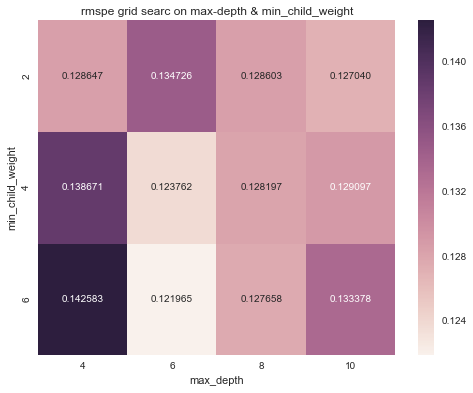

In [309]:
num_col=4
num_row=3
index_data = {'max_depth': list(itertools.chain(*([[i]*num_row for i in [4,6,8,10]]))), 
'min_child_weight':[2,4,6]*num_col}
frame = DataFrame(index_data)
for index,row in frame.iterrows():
    mask=(df_para_valid_model['max_depth']==row['max_depth']) &(df_para_valid_model['min_child_weight']==row['min_child_weight'])\
        &(df_para_valid_model['subsample']==0.95)&(df_para_valid_model['colsample_bytree']==0.95)\
        &(df_para_valid_model['eta']==0.3) &( df_para_valid_model['early_stopping_round']==33)
    frame.loc[index,'rmspe']= df_para_valid_model.loc[mask,'valid_result'].values[0]

    
plt.figure(figsize=[2*num_col,2*num_row])
ax=plt.axes()
sns.heatmap(pd.pivot_table(frame,index='min_child_weight',columns='max_depth',values='rmspe'),
            annot=True,fmt='.6f',ax=ax            
           )
ax.set_title('rmspe grid searc on max-depth & min_child_weight')
plt.show()

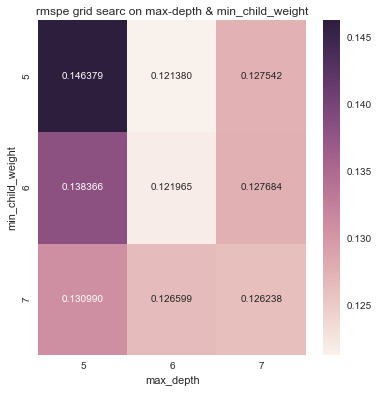

In [310]:
num_col=3
num_row=3
index_data = {'max_depth': list(itertools.chain(*([[i]*num_row for i in [5,6,7]]))), 
'min_child_weight':[5,6,7]*num_col}
frame = DataFrame(index_data)
for index,row in frame.iterrows():
    mask=(df_para_valid_model['max_depth']==row['max_depth']) &(df_para_valid_model['min_child_weight']==row['min_child_weight'])\
        &(df_para_valid_model['subsample']==0.95)&(df_para_valid_model['colsample_bytree']==0.95)\
        &(df_para_valid_model['eta']==0.3) &( df_para_valid_model['early_stopping_round']==33)
    frame.loc[index,'rmspe']= df_para_valid_model.loc[mask,'valid_result'].values[0]

    
plt.figure(figsize=[2*num_col,2*num_row])
ax=plt.axes()
sns.heatmap(pd.pivot_table(frame,index='min_child_weight',columns='max_depth',values='rmspe'),
            annot=True,fmt='.6f',ax=ax            
           )
ax.set_title('rmspe grid searc on max-depth & min_child_weight')
plt.show()

#### 4.7.2 展示 subsample 和 colsample_bytree 的grid search结果

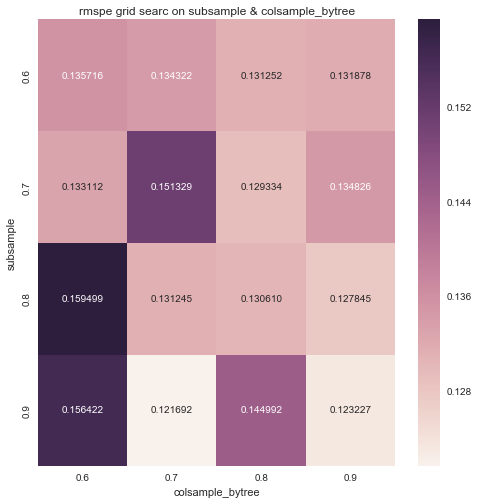

In [351]:
num_col=4
num_row=4
index_data = {'subsample': list(itertools.chain(*([[i]*num_row for i in [0.6,0.7,0.8,0.9]]))), 
'colsample_bytree':[0.6,0.7,0.8,0.9]*num_col}
frame = DataFrame(index_data)

for index,row in frame.iterrows():
    mask=(df_para_valid_model['max_depth']==6) &(df_para_valid_model['min_child_weight']==5)\
        &(df_para_valid_model['subsample']>(row['subsample']-0.001))&(df_para_valid_model['subsample']<(row['subsample']+0.001))\
        &(df_para_valid_model['colsample_bytree']>(row['colsample_bytree']-0.001))&(df_para_valid_model['colsample_bytree']<(row['colsample_bytree']+0.001))\
        &(df_para_valid_model['eta']==0.3) &( df_para_valid_model['early_stopping_round']==33)
    assert np.sum(mask)==1
    frame.loc[index,'rmspe']= df_para_valid_model.loc[mask,'valid_result'].values[0]
    
plt.figure(figsize=[2*num_col,2*num_row])
ax=plt.axes()
sns.heatmap(pd.pivot_table(frame,index='subsample',columns='colsample_bytree',values='rmspe'),
            annot=True,fmt='.6f',ax=ax            
           )
ax.set_title('rmspe grid searc on subsample & colsample_bytree')
plt.show()

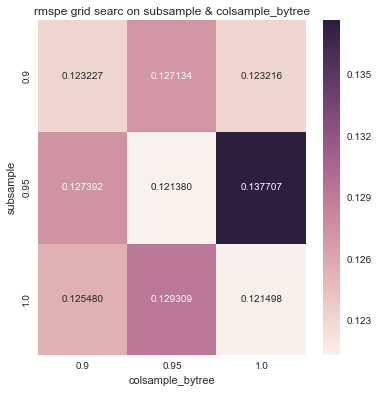

In [352]:
num_col=3
num_row=3
index_data = {'subsample': list(itertools.chain(*([[i]*num_row for i in [0.9,0.95,1.0]]))), 
'colsample_bytree':[0.9,0.95,1.0]*num_col}
frame = DataFrame(index_data)

for index,row in frame.iterrows():
    mask=(df_para_valid_model['max_depth']==6) &(df_para_valid_model['min_child_weight']==5)\
        &(df_para_valid_model['subsample']>(row['subsample']-0.001))&(df_para_valid_model['subsample']<(row['subsample']+0.001))\
        &(df_para_valid_model['colsample_bytree']>(row['colsample_bytree']-0.001))&(df_para_valid_model['colsample_bytree']<(row['colsample_bytree']+0.001))\
        &(df_para_valid_model['eta']==0.3) &( df_para_valid_model['early_stopping_round']==33)
    assert np.sum(mask)==1
    frame.loc[index,'rmspe']= df_para_valid_model.loc[mask,'valid_result'].values[0]
    
plt.figure(figsize=[2*num_col,2*num_row])
ax=plt.axes()
sns.heatmap(pd.pivot_table(frame,index='subsample',columns='colsample_bytree',values='rmspe'),
            annot=True,fmt='.6f',ax=ax            
           )
ax.set_title('rmspe grid searc on subsample & colsample_bytree')
plt.show()

#### 4.7.3 展示 eta 和 early_stop_round 的grid search结果

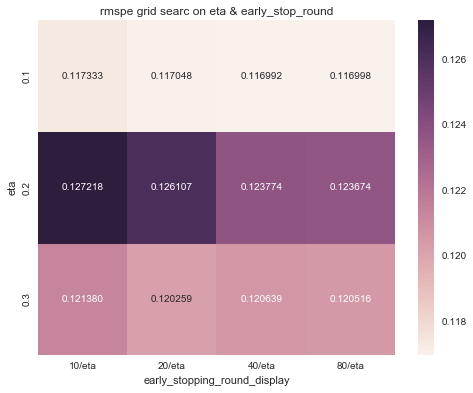

In [387]:
frame = DataFrame([])
num_col=3
num_row=4
frame['eta']=[0.1,0.2,0.3]*num_row
frame['ratio']=list(itertools.chain(*([[i]*num_col for i in [10,20,40,80]])))
frame['early_stopping_round']=[int(row['ratio']/row['eta']) for index,row in frame.iterrows()]
frame['early_stopping_round_display']=[str(int(row['ratio'])) +'/eta' for index,row in frame.iterrows()]



for index,row in frame.iterrows():
    mask=(df_para_valid_model['max_depth']==6) &(df_para_valid_model['min_child_weight']==5)\
        &(df_para_valid_model['subsample']>(0.95-0.001))&(df_para_valid_model['subsample']<(0.95+0.001))\
        &(df_para_valid_model['colsample_bytree']>(0.95-0.001))&(df_para_valid_model['colsample_bytree']<(0.95+0.001))\
        &(df_para_valid_model['eta']>(row['eta']-0.001))&(df_para_valid_model['eta']<(row['eta']+0.001))\
        &( df_para_valid_model['early_stopping_round']==row['early_stopping_round'])


    assert np.sum(mask)<=2
    frame.loc[index,'rmspe']= df_para_valid_model.loc[mask,'valid_result'].values[0]
    
plt.figure(figsize=[2*num_row,2*num_col])
ax=plt.axes()
sns.heatmap(pd.pivot_table(frame,columns='early_stopping_round_display',index='eta',values='rmspe'),
            annot=True,fmt='.6f',ax=ax            
           )
ax.set_title('rmspe grid searc on eta & early_stop_round')
plt.show()

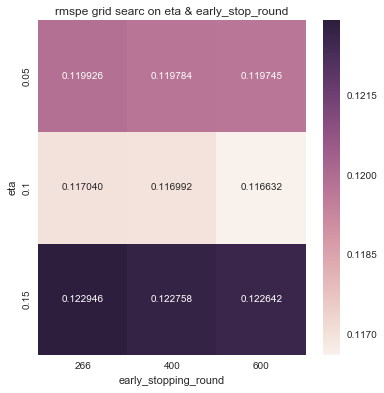

In [405]:
frame = DataFrame([])
num_col=3
num_row=3

frame['eta']=[0.05,0.1,0.15]*num_row
frame['early_stopping_round']=list(itertools.chain(*([[i]*num_col for i in [266,400,600]])))

for index,row in frame.iterrows():
    mask=(df_para_valid_model['max_depth']==6) &(df_para_valid_model['min_child_weight']==5)\
        &(df_para_valid_model['subsample']>(0.95-0.001))&(df_para_valid_model['subsample']<(0.95+0.001))\
        &(df_para_valid_model['colsample_bytree']>(0.95-0.001))&(df_para_valid_model['colsample_bytree']<(0.95+0.001))\
        &(df_para_valid_model['eta']>(row['eta']-0.001))&(df_para_valid_model['eta']<(row['eta']+0.001))\
        &( df_para_valid_model['early_stopping_round']==row['early_stopping_round'])

    assert np.sum(mask)==1
    frame.loc[index,'rmspe']= df_para_valid_model.loc[mask,'valid_result'].values[0]
    
plt.figure(figsize=[2*num_row,2*num_col])
ax=plt.axes()
sns.heatmap(pd.pivot_table(frame,columns='early_stopping_round',index='eta',values='rmspe'),
            annot=True,fmt='.6f',ax=ax            
           )
ax.set_title('rmspe grid searc on eta & early_stop_round')
plt.show()

### 4.8 将在验证集上效果最好的10个模型用来预测测试集，并输出
- 将输出的结果提交到kaggle上，并记录Leader board的得分

In [105]:
num_test=10
top_models=df_para_valid_model.sort_values(['valid_result'])[:num_test]['model_name']

#数据准备
mask_test=(modified_test_store_raw_df['Open']==1)
X_test=modified_test_store_raw_df.loc[mask_test,feature_x_list]
dtest=xgb.DMatrix(X_test[feature_x_list])
for i in top_models:
    print('-------Start to predict using model：'+i)
    #reload model from local
    reload_xgb_model=xgb.Booster()
    reload_xgb_model.load_model(os.path.join('model_saved',i) )
    
    #预测测试集
    test_data=modified_test_store_raw_df.copy()
    mask_test=(test_data['Open']==1)
    test_probs=reload_xgb_model.predict(dtest)
    test_data['Sales_Predicted']=0
    test_data.loc[mask_test,'Sales_Predicted']=test_probs

    #make submission
    result=pd.DataFrame({"Id":test_data['Id'],'Sales':np.expm1(test_data['Sales_Predicted'])})
    path='output_csv'
    file_name=os.path.splitext(i)[0]+'.csv'
    result.to_csv(os.path.join(path,file_name),index=False)

-------Start to predict using model：rsmpe11663sd42md6mcw5sd42s95cb95eta10es600.model
-------Start to predict using model：rsmpe11699sd42md6mcw5sd42s95cb95eta10es400.model
-------Start to predict using model：rsmpe11699sd42md6mcw5sd42s95cb95eta10es800.model
-------Start to predict using model：rsmpe11704sd42md6mcw5sd42s95cb95eta10es266.model
-------Start to predict using model：rsmpe11704sd42md6mcw5sd42s95cb95eta10es200.model
-------Start to predict using model：rsmpe11733sd42md6mcw5sd42s95cb95eta10es100.model
-------Start to predict using model：rsmpe11974sd42md6mcw5sd42s95cb95eta5es600.model
-------Start to predict using model：rsmpe11978sd42md6mcw5sd42s95cb95eta5es400.model
-------Start to predict using model：rsmpe11992sd42md6mcw5sd42s95cb95eta5es266.model
-------Start to predict using model：rsmpe12025sd42md6mcw5sd42s95cb95eta30es66.model


### 4.8 使用验证集效果最好的模型作为xgboost的基准模型
#### 4.8.1 保存模型，输出预测结果

In [121]:
#加载benchmark model
benchmark_xgboost_model=xgb.Booster()
benchmark_xgboost_model_name=top_models.values[0]
benchmark_xgboost_model.load_model(os.path.join('model_saved',benchmark_xgboost_model_name) )
#预测测试集
test_data=modified_test_store_raw_df.copy()
mask_test=(test_data['Open']==1)
test_probs=benchmark_xgboost_model.predict(dtest)
test_data['Sales_Predicted']=0
test_data.loc[mask_test,'Sales_Predicted']=test_probs

#make submission
result=pd.DataFrame({"Id":test_data['Id'],'Sales':np.expm1(test_data['Sales_Predicted'])})
path='output_csv'
file_name='benchmark_xgboost_model.csv'
result.to_csv(os.path.join(path,file_name),index=False)

# save model
benchmark_xgboost_model.save_model(os.path.join('model_saved','benchmark_xgboost_model.model'))

In [124]:
print('Paras for benchmark_xgboost_model:')
display(df_para_valid_model.sort_values(['valid_result'])[:1])

Paras for benchmark_xgboost_model:


,eta,max_depth,min_child_weight,subsample,colsample_bytree,seed,early_stopping_round,dict_key,train_time,model_name,valid_result
56,0.1,6,5,0.95,0.95,42,600,"(0.1, 6.0, 5.0, 0.95, 0.95, 42.0, 600.0)",8461.0,rsmpe11663sd42md6mcw5sd42s95cb95eta10es600.model,0.116632


In [472]:
print('Total training time=%.1f seconds'%np.sum(df_para_valid_model.train_time))
print('Total training time=%.1f minutes'%((np.sum(df_para_valid_model.train_time))/60))
print('Total training time=%.1f hours'%((np.sum(df_para_valid_model.train_time))/3600))

Total training time=156820.0 seconds
Total training time=2613.7 minutes
Total training time=43.6 hours


#### 4.8.2 保存最优参数

In [222]:
param_xgboost_benchmark=dict(const_para.items() + best_paras.items())
param_xgboost_benchmark['best_early_stopping_round']=best_early_stopping_round

path='model_saved'
file_param_xgboost_benchmark='param_xgboost_benchmark.pickle'
pickle.dump( param_xgboost_benchmark, open( os.path.join(path, file_param_xgboost_benchmark), "wb" ) )

In [223]:
def load_param_earlyStopRound(file_add):
    data=pickle.load( open( file_add, "rb" ) )
    early_top_round=data['best_early_stopping_round']
    del data['best_early_stopping_round']
    return data,early_top_round
    
load_param_earlyStopRound(os.path.join(path, file_param_xgboost_benchmark))

({'colsample_bytree': 0.95,
  'eta': 0.10000000000000001,
  'max_depth': 6,
  'min_child_weight': 5,
  'objective': 'reg:linear',
  'seed': 42,
  'silent': 1,
  'subsample': 0.95},
 600)

测试集的Public Score和Private Score为0.11547和0.12153

### 4.9 最终模型结果分析
#### 4.9.1 feature importance

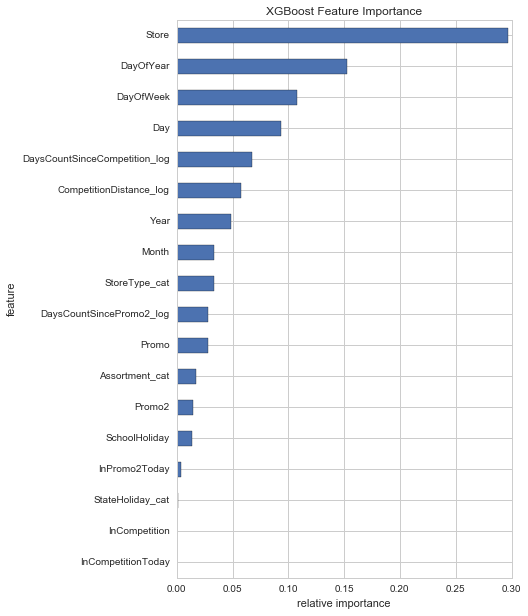

In [125]:
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
features=feature_x_list
def create_feature_map(features):
    outfile=open('xgb.fmap','w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feat))
    outfile.close()
create_feature_map(features)
importance=benchmark_xgboost_model.get_fscore(fmap='xgb.fmap')
importance=sorted(importance.items(),key=operator.itemgetter(1))

df=pd.DataFrame(importance,columns=['feature','fscore'])
df['fscore']=df['fscore']/df['fscore'].sum()

featp=df.plot(kind='barh',x='feature',y='fscore',legend=False,figsize=(6,10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
# fig_featp=featp.get_figure()
# fig_featp.savefig('Kaggle_Kernel_3_XGBoost_Feature_Importance/feature_importance_xgb.png',bbox_inches='tight',pad_inches=1)


#### 4.10 分析benchmark_xgboost_model模型训练集上的的误差值
##### 4.10.1 计算得到 Sales_Predicted, Abs_Percent_Error

In [128]:
# 定义mask_valid
startValidDate='2015-06-15'
mask_valid=(modified_train_store_raw_df['Date']>=startValidDate)\
            & (modified_train_store_raw_df['Open']==1)\
            & (modified_train_store_raw_df['Sales']>0)
# 使用benchmark_xgboost_model对dvalid进行预测，并赋值给valid_data
valid_data=modified_train_store_raw_df.copy()
valid_data['Sales_Predicted']=0
valid_prediction=benchmark_xgboost_model.predict(dvalid)
valid_data.loc[mask_valid,'Sales_Predicted']=np.expm1(valid_prediction)

In [132]:
valid_data['Abs_Percent_Error']=0
valid_data.loc[mask_valid,'Abs_Percent_Error']=abs(valid_data.loc[mask_valid,'Sales_Predicted']-valid_data.loc[mask_valid,'Sales'])/valid_data.loc[mask_valid,'Sales']

##### 4.10.2 对 Abs_Percent_Error 进行可视化

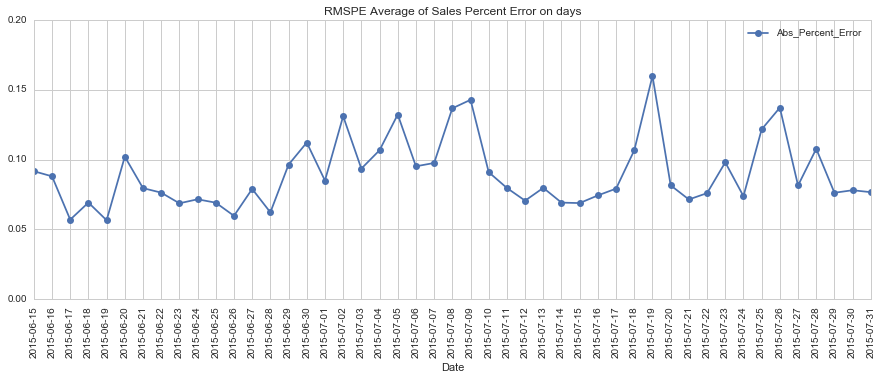

In [424]:
mask=(modified_train_store_raw_df['Date']>=startValidDate) & valid_data.Sales>0
RMSPE_Sales_days=valid_data[mask].groupby('Date')['Abs_Percent_Error'].apply(np.mean
                                                                            )

fig,(axis1)=plt.subplots(1,1,sharex=True,figsize=(15,5))

#plot average sales abs percent error
ax1=RMSPE_Sales_days.plot(legend=True,ax=axis1,ylim=[0,0.2],marker='o',title='RMSPE Average of Sales Percent Error on days')
ax1.set_xticks(range(len(RMSPE_Sales_days)))
ax1.set_xticklabels(RMSPE_Sales_days.index.tolist(),rotation=90)
plt.show()

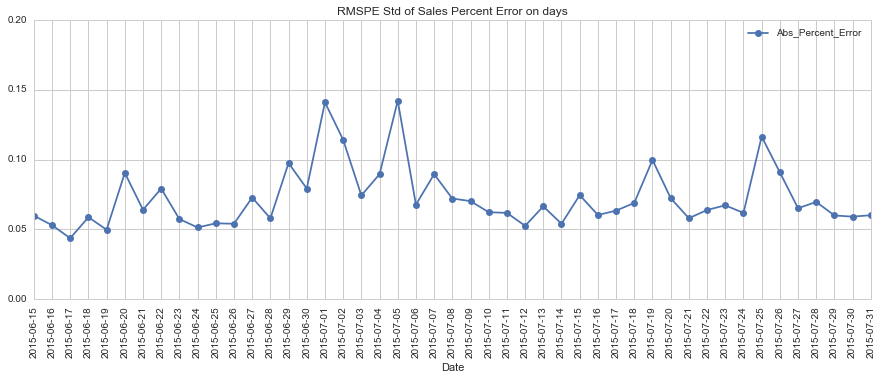

In [425]:
mask=(modified_train_store_raw_df['Date']>=startValidDate) & valid_data.Sales>0
RMSPE_Sales_days=valid_data[mask].groupby('Date')['Abs_Percent_Error'].apply(np.std
                                                                            )

fig,(axis1)=plt.subplots(1,1,sharex=True,figsize=(15,5))

#plot average sales abs percent error
ax1=RMSPE_Sales_days.plot(legend=True,ax=axis1,ylim=[0,0.2],marker='o',title='RMSPE Std of Sales Percent Error on days')
ax1.set_xticks(range(len(RMSPE_Sales_days)))
ax1.set_xticklabels(RMSPE_Sales_days.index.tolist(),rotation=90)
plt.show()

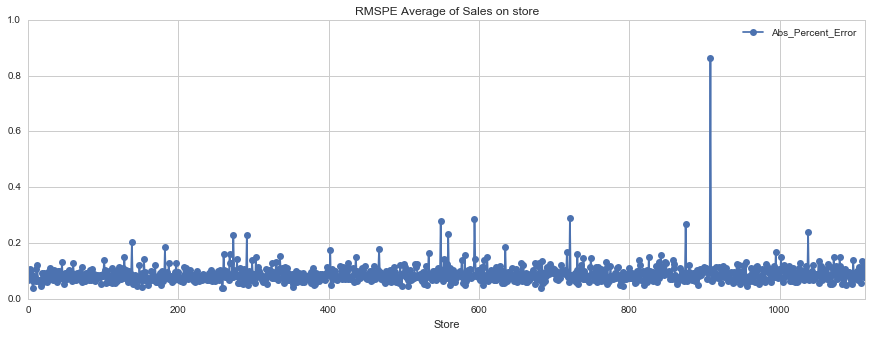

In [446]:
mask=(modified_train_store_raw_df['Date']>=startValidDate) & valid_data.Sales>0

RMSPE_Sales_store=valid_data[mask].groupby('Store')['Abs_Percent_Error'].apply(np.mean)

fig,(axis1)=plt.subplots(1,1,sharex=True,figsize=(15,5))

#plot average sales abs percent error
ax1=RMSPE_Sales_store.plot(legend=True,ax=axis1,ylim=[0,1.0],marker='o',title='RMSPE Average of Sales on store')

plt.show()

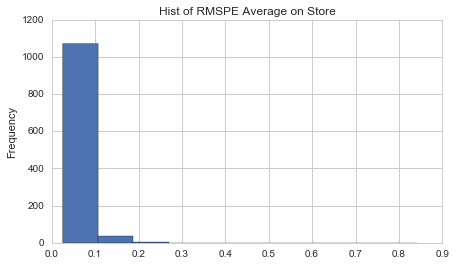

In [463]:
RMSPE_Sales_store.plot(kind='hist',figsize=[7,4])
plt.title('Hist of RMSPE Average on Store')
plt.show()

In [464]:
np.sum(RMSPE_Sales_store<0.1)

1051

In [447]:
# 显示
list_avg_store=RMSPE_Sales_store.sort_values(ascending=False)[:10]
list_avg_store

Store
908     0.862703
721     0.289193
594     0.287250
549     0.280113
875     0.268749
1038    0.239938
559     0.233098
291     0.228918
273     0.228608
138     0.203011
Name: Abs_Percent_Error, dtype: float64

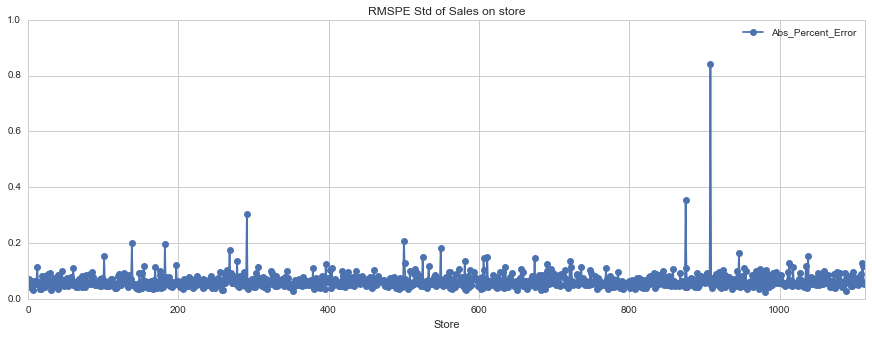

In [448]:
mask=(modified_train_store_raw_df['Date']>=startValidDate) & valid_data.Sales>0

RMSPE_Sales_store=valid_data[mask].groupby('Store')['Abs_Percent_Error'].apply(np.std)

fig,(axis1)=plt.subplots(1,1,sharex=True,figsize=(15,5))

#plot average sales abs percent error
ax1=RMSPE_Sales_store.plot(legend=True,ax=axis1,ylim=[0,1.0],marker='o',title='RMSPE Std of Sales on store')

plt.show()

In [449]:
# 显示
list_std_store=RMSPE_Sales_store.sort_values(ascending=False)[:10]
list_std_store

Store
908     0.840774
875     0.354612
291     0.303157
500     0.207377
138     0.198867
182     0.197418
549     0.182847
268     0.175509
946     0.164848
1038    0.155006
Name: Abs_Percent_Error, dtype: float64

In [450]:
print ('Num Of Same Element='+str(len((set(list(list_avg_store.keys())))&(set(list(list_std_store.keys()))))))

Num Of Same Element=6


#### 4.10.3 在验证集上，使用benchmark_xgboost_model的预测值与实际值差值绝对值

mean=628.1
median=448.9
max=32622.6
min=0.0
sum=28799726.0
sum_percent=8.79%
median_percent=6.84%


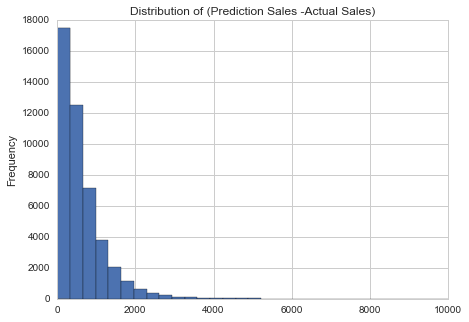

In [415]:
mask=(modified_train_store_raw_df['Date']>=startValidDate) & (valid_data.Open==1)
y_diff=np.abs(valid_data[mask]['Sales']- valid_data[mask]['Sales_Predicted'])
print 'mean={:.1f}'.format(y_diff.mean())
print 'median={:.1f}'.format(y_diff.median())
print 'max={:.1f}'.format(y_diff.max())
print 'min={:.1f}'.format(y_diff.min())
print 'sum={:.1f}'.format(y_diff.sum())
print 'sum_percent={:.2f}%'.format(100.0*y_diff.sum()/abs(np.sum(valid_data[mask]['Sales'])))
print 'median_percent={:.2f}%'.format(100.0*y_diff.median()/abs(np.median(valid_data[mask]['Sales'])))


fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
#Sales
_ =y_diff.plot(kind='hist',bins=100,xlim=(0,10000),ax=axis1,title='Distribution of (Prediction Sales -Actual Sales)')



### 4.11 训练数据不适用outlier

#### 4.11.1 构造train_df数据，valid_df数据,test_df数据

In [234]:
startValidDate='2015-06-15'

mask_train_Outlier=(modified_train_store_raw_df['Date']<startValidDate)  \
            & (modified_train_store_raw_df['Open']==1) & (modified_train_store_raw_df['Sales']>0)
    
df_train_Outlier=modified_train_store_raw_df.loc[mask_train_Outlier,feature_x_list]

#### 4.11.2 构造XGBoost模型所需要的train, valid数据

In [235]:
X_train_Outlier=df_train_Outlier

y_train_Outlier=modified_train_store_raw_df.loc[mask_train_Outlier,'SalesLog']

#### 4.11.3 验证valid数据中每个feature是否有不包含在train数据中的unique数值

In [236]:
mask_test=(modified_test_store_raw_df['Open']==1)

for ii in feature_x_list:
    set_unique_train_Outlier=set(df_train_Outlier[ii].unique())
    set_unique_valid=set(df_valid[ii].unique())
    set_unique_test=set((modified_test_store_raw_df[mask_test][ii]).unique())

    
    if set_unique_train_Outlier.issuperset(set_unique_valid) &(set_unique_train_Outlier.issuperset(set_unique_test) ):
        print '{0: <30}'.format(ii),'= 1'
    else:
        print '{0: <30}'.format(ii),'= 0'

Store                          = 1
DayOfWeek                      = 1
Year                           = 1
Month                          = 1
Day                            = 1
DayOfYear                      = 1
StoreType_cat                  = 1
Assortment_cat                 = 1
StateHoliday_cat               = 1
SchoolHoliday                  = 1
Promo                          = 1
Promo2                         = 1
InPromo2Today                  = 1
DaysCountSinceCompetition_log  = 1
InCompetition                  = 1
InCompetitionToday             = 1
CompetitionDistance_log        = 1
DaysCountSincePromo2_log       = 1


#### 4.11.4 使用 xgboost_benchmark_model的参数来训练模型

In [237]:
path='model_saved'
file_param_xgboost_benchmark='param_xgboost_benchmark.pickle'
para_xgboost_benchmark,earlyStopRound_xgboost_benchmark=load_param_earlyStopRound(os.path.join(path, file_param_xgboost_benchmark))

In [238]:
earlyStopRound_xgboost_benchmark

600

In [239]:
para_xgboost_benchmark

{'colsample_bytree': 0.95,
 'eta': 0.10000000000000001,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

In [240]:
#构造xgboost所需要的训练集和预测集
dtrain_Outlier=xgb.DMatrix(X_train_Outlier[feature_x_list],y_train_Outlier)

watchlist=[(dtrain_Outlier,'train'),(dvalid,'eval')]
num_boost_round=20000 #最大训练次数



print('----------starting to train model using paras-------')
start_time = time.time()
display(para_xgboost_benchmark)
print('early_stopping_round=%s'%earlyStopRound_xgboost_benchmark)

gbm_0=xgb.train(para_xgboost_benchmark,dtrain_Outlier,num_boost_round,evals=watchlist,early_stopping_rounds=earlyStopRound_xgboost_benchmark,feval=rmspe_xg,verbose_eval=False)

#用训练好的模型预测验证集
print('Validating')
yhat=gbm_0.predict(xgb.DMatrix(X_valid[feature_x_list]))
error=rmspe(np.exp(y_valid),np.exp(yhat))
print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))


#将模型保存到本地
train_time=(int)(time.time() - start_time)
print("-------------Trained model done: %s seconds -------------" % train_time)


----------starting to train model using paras-------


{'colsample_bytree': 0.95,
 'eta': 0.10000000000000001,
 'max_depth': 6,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.95}

early_stopping_round=600


Will train until eval error hasn't decreased in 600 rounds.
Stopping. Best iteration:
[5602]	train-rmspe:0.107143	eval-rmspe:0.123070



Validating
XGBoost模型在验证集上的RMSPE:0.123204
-------------Trained model done: 5408 seconds -------------
